In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [6]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [7]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.55124656])

In [8]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [9]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.486489
 tiger         0.343104
 quixotic      0.083821
 merciful      0.045366
 fireman       0.034689
 touch         0.001894
 sweltering    0.000652
 shelf         0.000577
 cute          0.000312
 barbarous     0.000302
 adhesive      0.000302
 wrap          0.000288
 lip           0.000285
 playground    0.000244
 rigid         0.000238
 lethal        0.000203
 future        0.000184
 dependent     0.000177
 eight         0.000155
 rain          0.000152
 nonchalant    0.000151
 clammy        0.000118
 offer         0.000103
 change        0.000102
 damp          0.000090
 dtype: float64}

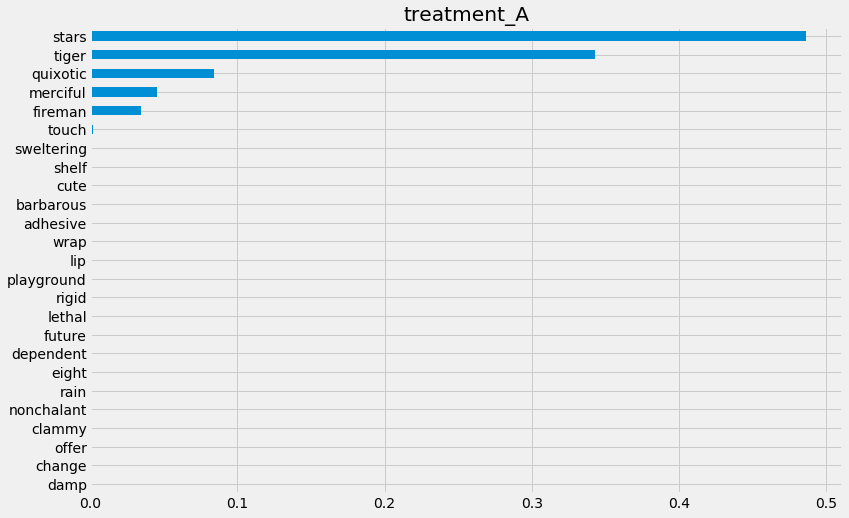

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [11]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': stars         0.962595
 tiger         0.741225
 quixotic      0.183951
 merciful      0.077581
 fireman       0.075747
 touch         0.004322
 sweltering    0.000695
 wrap          0.000621
 shelf         0.000302
 barbarous     0.000229
 lethal        0.000107
 future        0.000065
 clammy        0.000056
 change        0.000053
 offer         0.000040
 cute          0.000037
 dependent     0.000023
 playground   -0.000002
 lip          -0.000022
 rain         -0.000032
 eight        -0.000044
 damp         -0.000054
 nonchalant   -0.000057
 adhesive     -0.000083
 rigid        -0.000130
 dtype: float64}

In [12]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.2573859691619873 seconds


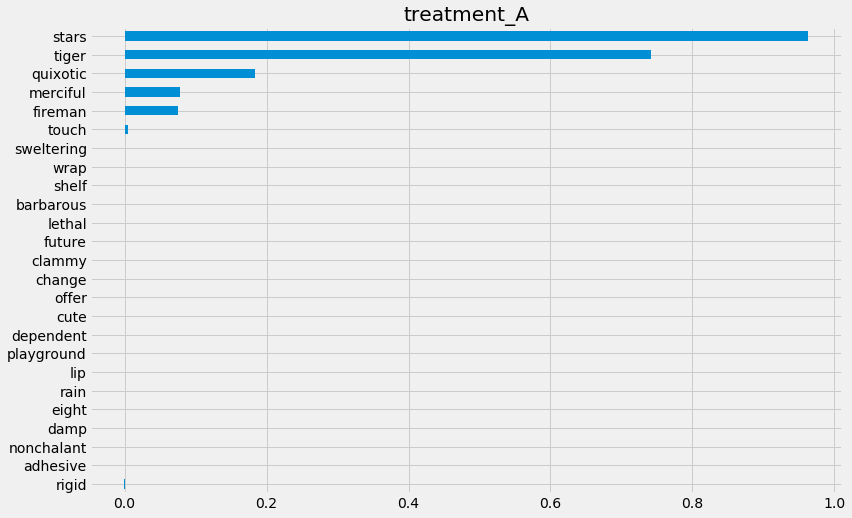

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [14]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.4103600978851318 seconds


In [15]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.962595
tiger         0.741225
quixotic      0.183951
merciful      0.077581
fireman       0.075747
touch         0.004322
sweltering    0.000695
wrap          0.000621
shelf         0.000302
barbarous     0.000229
lethal        0.000107
future        0.000065
clammy        0.000056
change        0.000053
offer         0.000040
cute          0.000037
dependent     0.000023
playground   -0.000002
lip          -0.000022
rain         -0.000032
eight        -0.000044
damp         -0.000054
nonchalant   -0.000057
adhesive     -0.000083
rigid        -0.000130
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

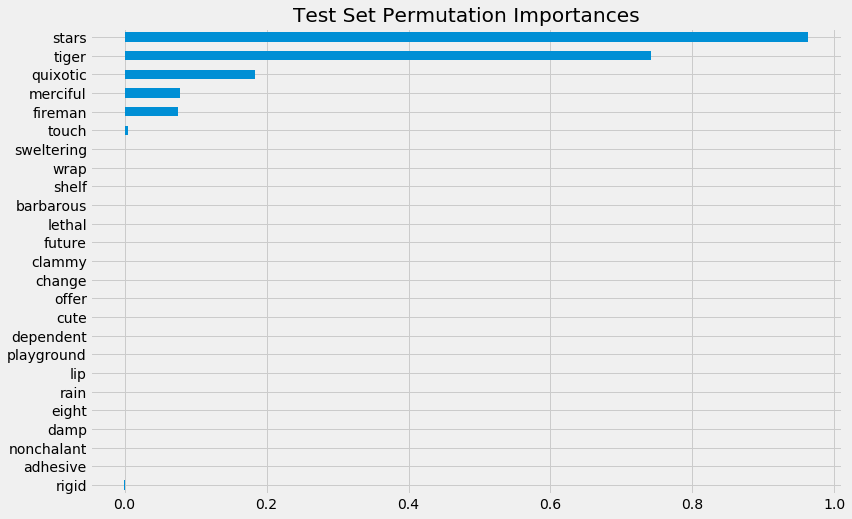

In [16]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [17]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

stars         0.979218
tiger         0.755084
quixotic      0.178054
merciful      0.080888
fireman       0.076262
touch         0.005695
wrap          0.001916
sweltering    0.001616
adhesive      0.001341
shelf         0.001234
rigid         0.001205
barbarous     0.001200
playground    0.001101
cute          0.001020
lip           0.000883
offer         0.000883
clammy        0.000804
future        0.000763
nonchalant    0.000757
lethal        0.000701
dependent     0.000606
eight         0.000584
damp          0.000553
change        0.000413
rain          0.000339
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

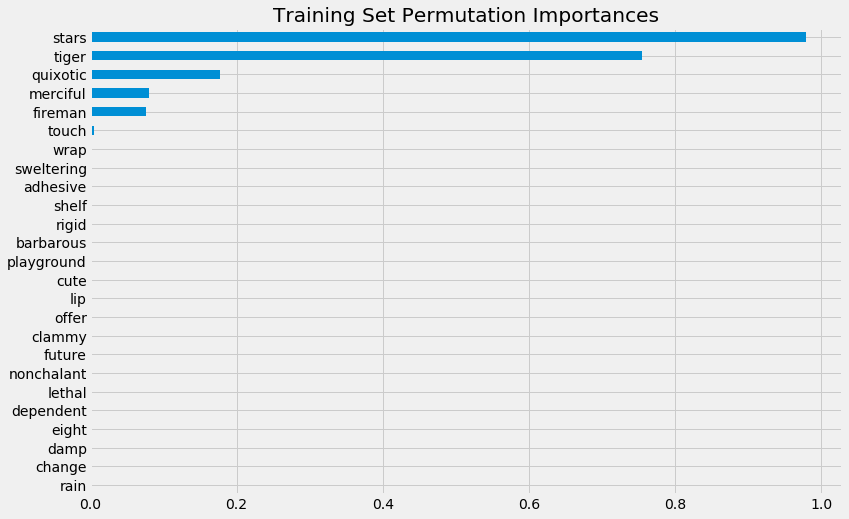

In [18]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 3.94366656e-02, -2.29530311e-01,  1.42158979e-02, ...,
         -1.62871545e-04,  5.82372435e-04,  2.88715214e-04],
        [-7.54144307e-02,  1.85798470e-01, -1.90590808e-02, ...,
         -3.17803418e-05, -3.82232450e-04, -3.76163889e-05],
        [ 3.89606913e-02,  1.75083435e-01, -1.63511157e-02, ...,
         -1.32024179e-03, -1.94442532e-04,  2.52281080e-04],
        ...,
        [ 8.43145649e-02,  2.30140122e-01,  1.60212264e-02, ...,
          2.85981707e-06, -1.13863828e-06, -2.36089392e-05],
        [ 1.11671050e-01, -7.22417643e-02,  1.41737832e-03, ...,
         -2.59095285e-05, -9.11502869e-05,  4.50328633e-05],
        [-2.63074721e-02,  1.38382654e-01, -2.21219286e-02, ...,
         -1.03485074e-04, -2.62784688e-04, -6.61313016e-05]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([1.45973193e-01, 1.22802198e-01, 1.92613910e-02, 3.90087021e-02,
       2.65509008e-02, 3.57503802e-04, 7.94938074e-04, 4.61141671e-03,
       9.36039134e-04, 1.25960368e-04, 4.44237157e-04, 2.37262549e-04,
       2.96173809e-04, 3.57679078e-04, 7.35552208e-04, 1.42282895e-04,
       2.40108166e-04, 2.84783457e-04, 4.65052691e-04, 1.54977802e-03,
       1.82520000e-04, 7.36111819e-04, 4.84202462e-04, 5.03599958e-04,
       2.75059742e-04])

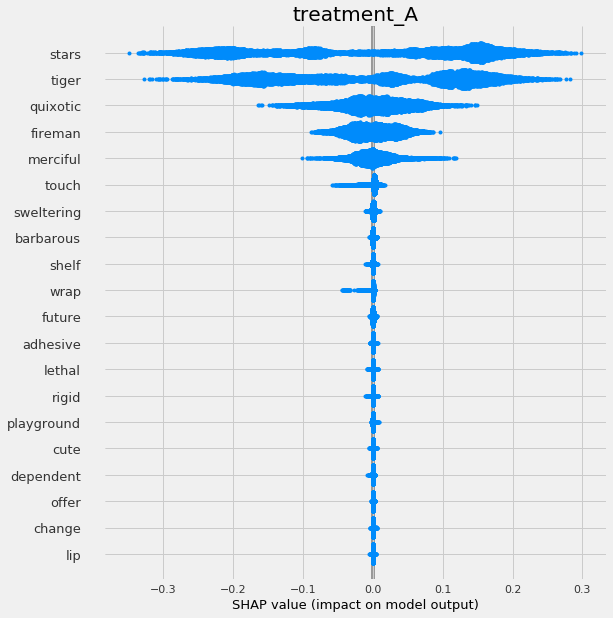

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

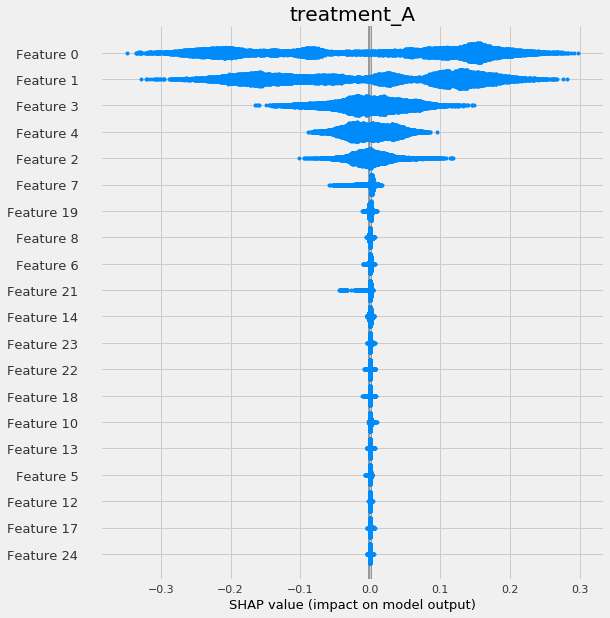

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

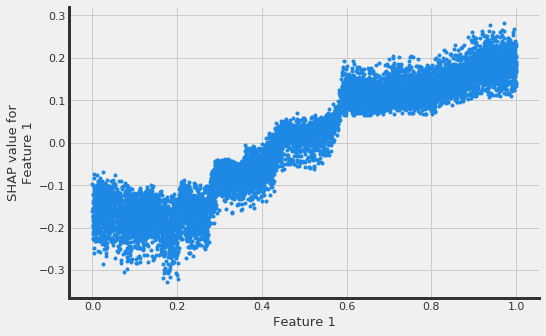

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

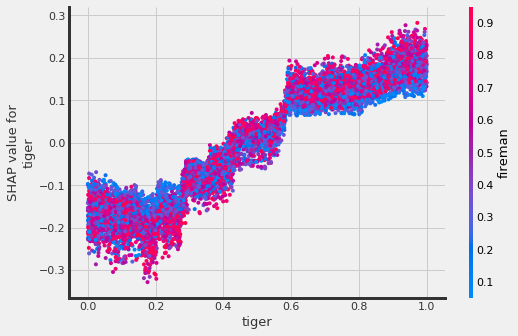

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

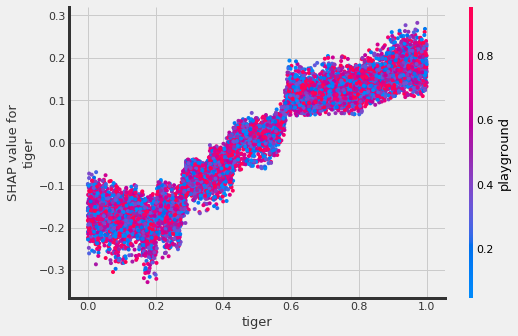

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [26]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.5540839]), array([0.53933868]), array([0.56882913]))

In [27]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [28]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.384675
 tiger         0.254866
 quixotic      0.059036
 merciful      0.053492
 fireman       0.033534
 future        0.017594
 sweltering    0.015322
 adhesive      0.014223
 wrap          0.014126
 clammy        0.012104
 playground    0.012003
 shelf         0.011924
 barbarous     0.011038
 rigid         0.010894
 rain          0.010578
 nonchalant    0.010465
 change        0.010405
 offer         0.010258
 cute          0.009573
 lethal        0.009008
 touch         0.008742
 lip           0.008528
 dependent     0.007199
 eight         0.005438
 damp          0.004975
 dtype: float64}

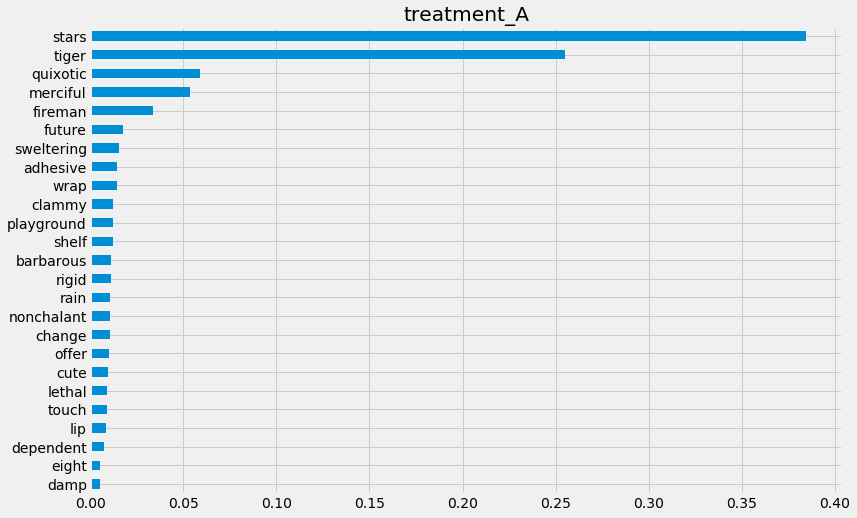

In [29]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [30]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': stars         0.567860
 tiger         0.404623
 quixotic      0.064612
 merciful      0.038721
 fireman       0.032291
 future        0.012999
 wrap          0.011618
 adhesive      0.011075
 sweltering    0.006733
 clammy        0.005775
 change        0.005465
 rain          0.005355
 touch         0.005151
 barbarous     0.004527
 dependent     0.003598
 playground    0.003543
 rigid         0.003508
 nonchalant    0.003497
 lip           0.003109
 offer         0.002861
 shelf         0.002399
 lethal        0.001886
 cute          0.001628
 eight         0.000871
 damp          0.000650
 dtype: float64}

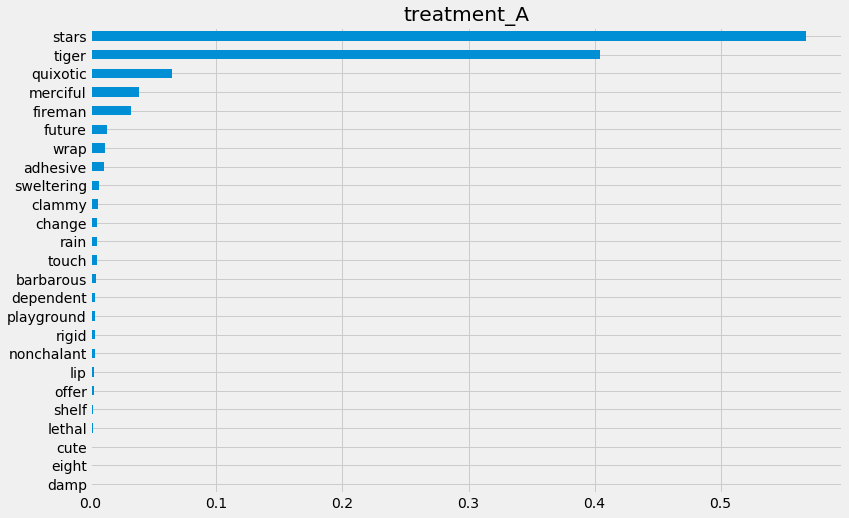

In [31]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [32]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.0853099822998047 seconds


In [33]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.567860
tiger         0.404623
quixotic      0.064612
merciful      0.038721
fireman       0.032291
future        0.012999
wrap          0.011618
adhesive      0.011075
sweltering    0.006733
clammy        0.005775
change        0.005465
rain          0.005355
touch         0.005151
barbarous     0.004527
dependent     0.003598
playground    0.003543
rigid         0.003508
nonchalant    0.003497
lip           0.003109
offer         0.002861
shelf         0.002399
lethal        0.001886
cute          0.001628
eight         0.000871
damp          0.000650
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

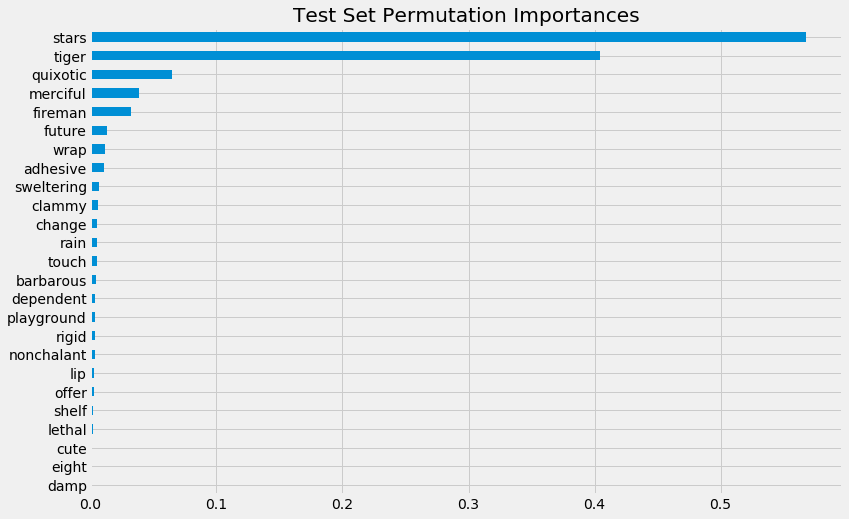

In [34]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [35]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[ 0.01983429, -0.1980894 ,  0.00685216, ..., -0.00420184,
         -0.00505335,  0.00887105],
        [-0.12117409,  0.23882282, -0.03173552, ..., -0.00303379,
          0.00405849, -0.00871143],
        [ 0.0129052 ,  0.21498206, -0.03055744, ..., -0.02454731,
          0.01187846, -0.03121241],
        ...,
        [ 0.02176915,  0.26183205,  0.02514154, ...,  0.02521532,
          0.03471841,  0.00165231],
        [ 0.09952416, -0.06701196,  0.00206727, ...,  0.0037859 ,
          0.0130603 ,  0.00089347],
        [-0.01132435,  0.12937684, -0.02672874, ..., -0.00077457,
          0.00556904, -0.01268997]])}

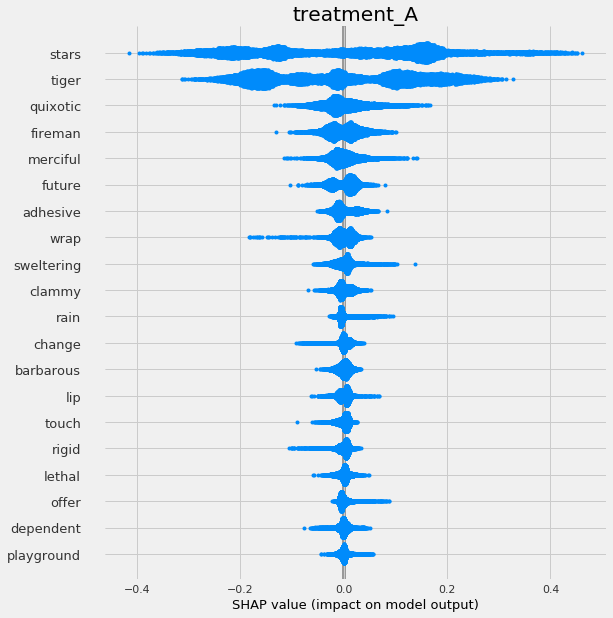

In [36]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

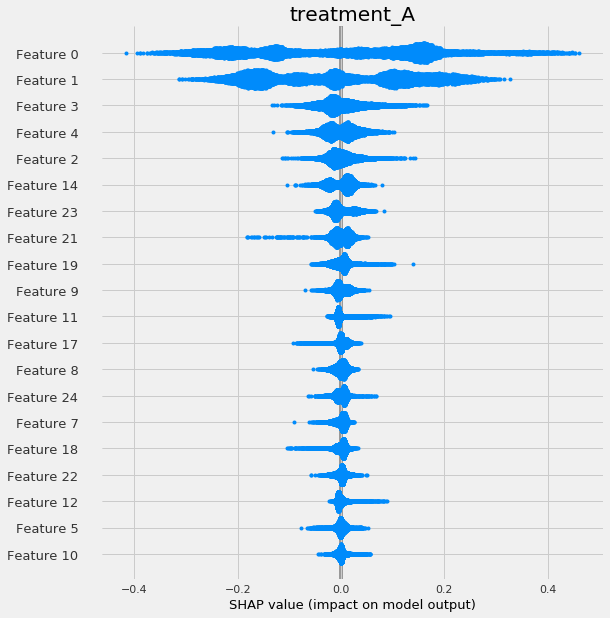

In [37]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

## X Learner

In [38]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

(array([0.49865807]), array([0.48473804]), array([0.5125781]))

In [39]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [40]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.451909
 tiger         0.323575
 quixotic      0.027299
 merciful      0.023991
 wrap          0.015435
 rain          0.014365
 sweltering    0.012960
 adhesive      0.011703
 fireman       0.010942
 nonchalant    0.010571
 lethal        0.009734
 future        0.009083
 shelf         0.008143
 barbarous     0.007333
 lip           0.007117
 playground    0.007064
 cute          0.006529
 offer         0.006323
 rigid         0.006248
 change        0.005930
 dependent     0.005665
 eight         0.004983
 clammy        0.004959
 touch         0.004267
 damp          0.003871
 dtype: float64}

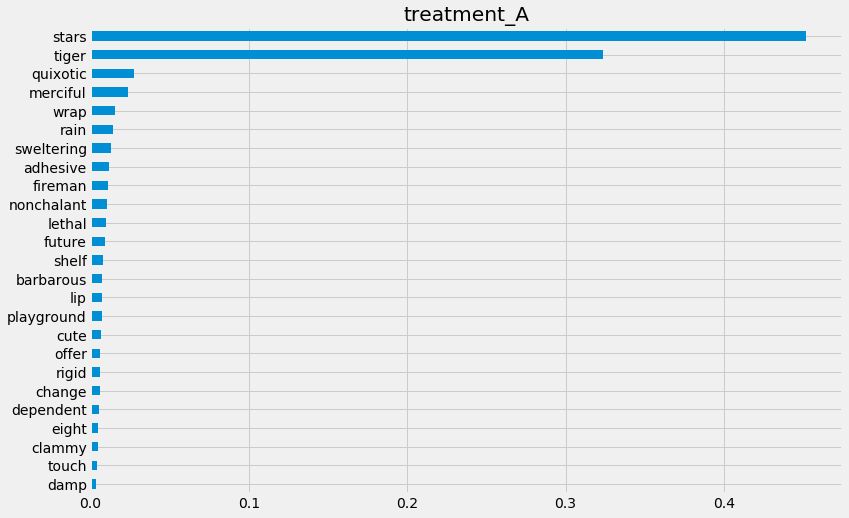

In [41]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [42]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': stars         0.852106
 tiger         0.591941
 quixotic      0.034504
 merciful      0.024898
 wrap          0.018366
 sweltering    0.015290
 rain          0.015165
 adhesive      0.014575
 lethal        0.012336
 future        0.011654
 fireman       0.010589
 nonchalant    0.009900
 shelf         0.007157
 barbarous     0.006110
 lip           0.005784
 playground    0.005575
 cute          0.005101
 change        0.004219
 rigid         0.003825
 offer         0.003547
 dependent     0.003187
 clammy        0.003115
 touch         0.002917
 eight         0.002577
 damp          0.001972
 dtype: float64}

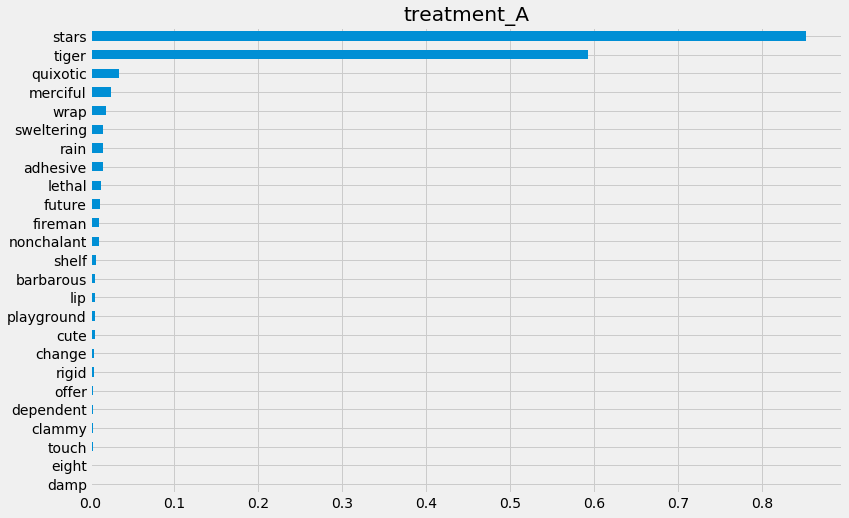

In [43]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [44]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.1362731456756592 seconds


In [45]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.852106
tiger         0.591941
quixotic      0.034504
merciful      0.024898
wrap          0.018366
sweltering    0.015290
rain          0.015165
adhesive      0.014575
lethal        0.012336
future        0.011654
fireman       0.010589
nonchalant    0.009900
shelf         0.007157
barbarous     0.006110
lip           0.005784
playground    0.005575
cute          0.005101
change        0.004219
rigid         0.003825
offer         0.003547
dependent     0.003187
clammy        0.003115
touch         0.002917
eight         0.002577
damp          0.001972
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

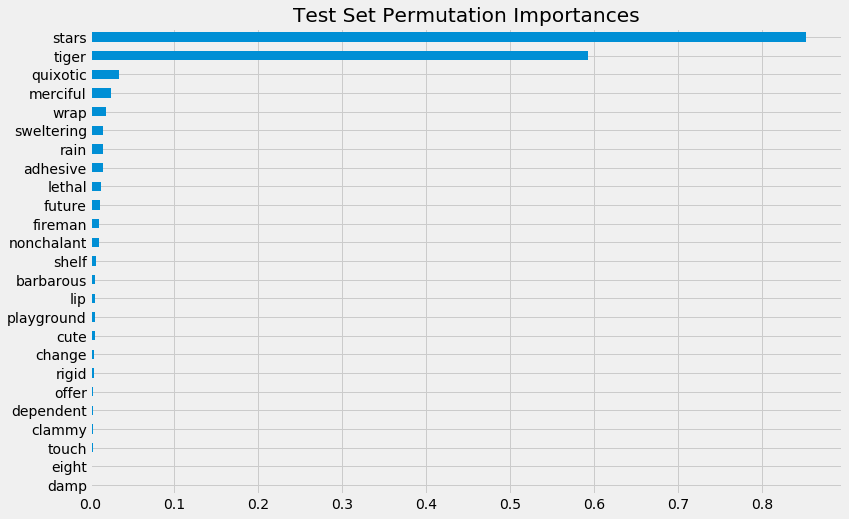

In [46]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [47]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[ 1.39587544e-02, -1.38111092e-01, -4.66281096e-04, ...,
         -5.34398610e-03, -7.19564955e-03,  1.08016212e-02],
        [-1.13233179e-01,  1.87891976e-01, -8.26238931e-03, ...,
         -6.04099568e-03,  5.62940200e-03, -2.01524533e-03],
        [-8.36121936e-02,  1.67828628e-01, -5.13376118e-03, ...,
         -2.39928248e-02,  2.82413204e-02, -1.34879032e-02],
        ...,
        [-9.21333349e-02,  1.79998101e-01,  2.97610014e-03, ...,
          1.03298453e-02,  3.22332256e-02, -7.79747422e-03],
        [ 8.20946132e-02, -3.97760850e-02,  1.05089795e-02, ...,
          4.26645134e-03,  1.61760581e-02,  5.25206615e-03],
        [-2.63176982e-02,  1.02573325e-01, -1.73067708e-04, ...,
         -7.49134980e-03,  3.28218192e-02, -3.68958547e-03]])}

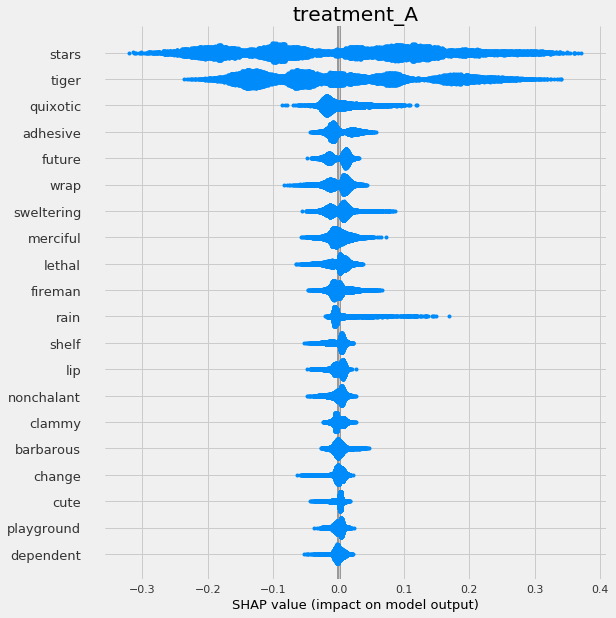

In [48]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

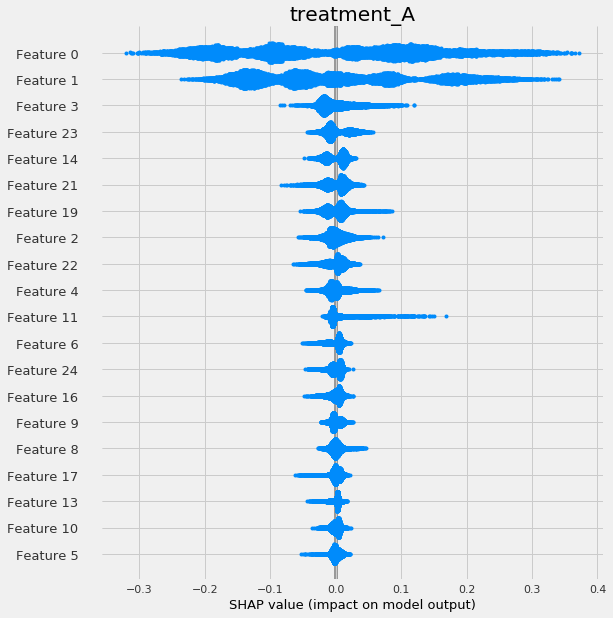

In [49]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

## R Learner

In [50]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [51]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': stars         0.229371
 tiger         0.182911
 merciful      0.052773
 rain          0.045701
 quixotic      0.035532
 dependent     0.034649
 playground    0.029319
 lip           0.029179
 sweltering    0.028628
 barbarous     0.026947
 nonchalant    0.026473
 lethal        0.025862
 adhesive      0.024912
 offer         0.024012
 shelf         0.022196
 fireman       0.020700
 damp          0.020668
 future        0.019985
 wrap          0.019723
 cute          0.018876
 change        0.017793
 touch         0.017618
 eight         0.016975
 clammy        0.016388
 rigid         0.012809
 dtype: float64}

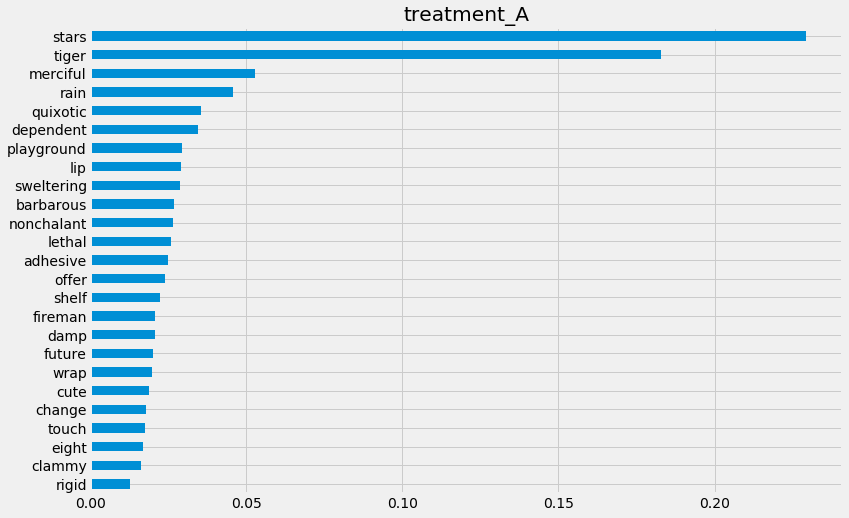

In [52]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [53]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': stars         0.317007
 tiger         0.259112
 rain          0.043181
 merciful      0.029149
 quixotic      0.024564
 sweltering    0.022064
 future        0.017083
 offer         0.016832
 dependent     0.016667
 wrap          0.015181
 lip           0.014977
 adhesive      0.013323
 nonchalant    0.013155
 lethal        0.011167
 fireman       0.010991
 barbarous     0.010426
 playground    0.010022
 clammy        0.009221
 change        0.009154
 damp          0.008008
 shelf         0.007940
 cute          0.005631
 touch         0.005509
 rigid         0.004789
 eight         0.004115
 dtype: float64}

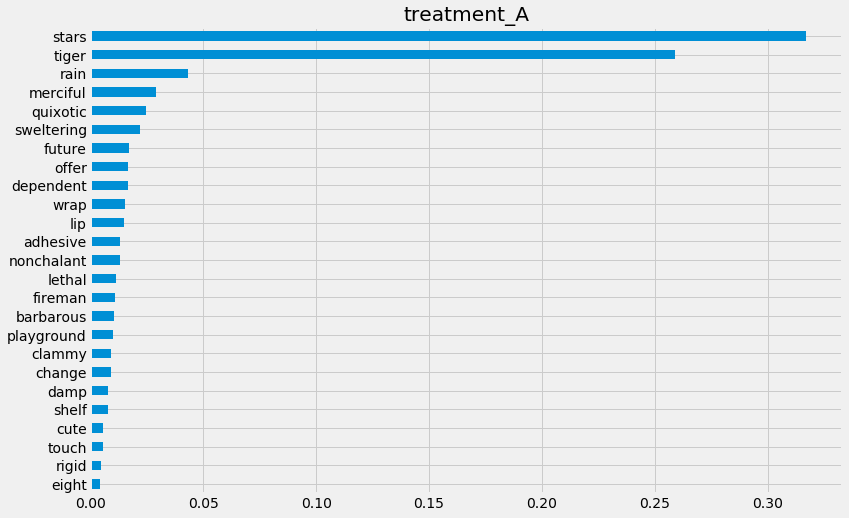

In [54]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [55]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.259948968887329 seconds


In [56]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

stars         0.317007
tiger         0.259112
rain          0.043181
merciful      0.029149
quixotic      0.024564
sweltering    0.022064
future        0.017083
offer         0.016832
dependent     0.016667
wrap          0.015181
lip           0.014977
adhesive      0.013323
nonchalant    0.013155
lethal        0.011167
fireman       0.010991
barbarous     0.010426
playground    0.010022
clammy        0.009221
change        0.009154
damp          0.008008
shelf         0.007940
cute          0.005631
touch         0.005509
rigid         0.004789
eight         0.004115
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

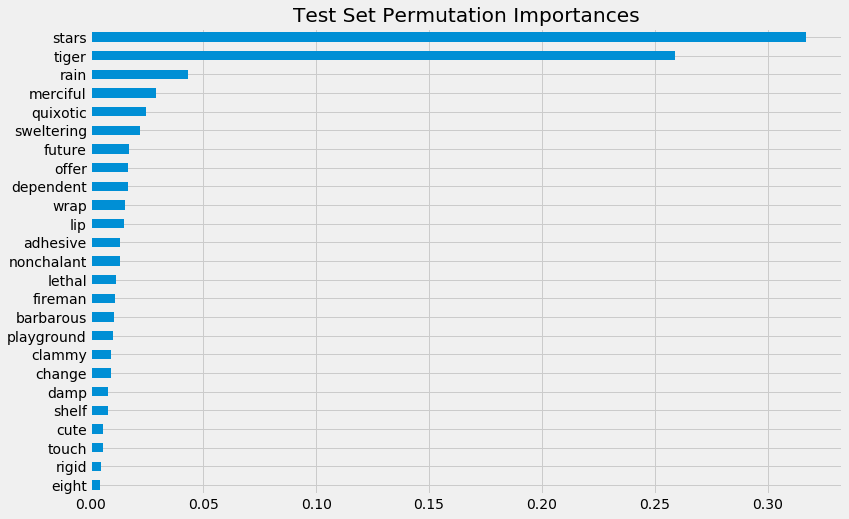

In [57]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [58]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[ 0.03023169, -0.12050095,  0.00054553, ..., -0.01171146,
         -0.01144764,  0.00517501],
        [-0.09549191,  0.15077295, -0.00517459, ..., -0.00820947,
          0.01215939,  0.00585136],
        [-0.09012906,  0.14228088, -0.00819578, ..., -0.03594954,
          0.01436807, -0.01736302],
        ...,
        [-0.12475088,  0.19588879, -0.00240182, ...,  0.00711909,
          0.02774982,  0.00973711],
        [ 0.05356909, -0.07152747,  0.00651961, ...,  0.00789984,
          0.01908949, -0.00387345],
        [-0.06715088,  0.08753955,  0.00163448, ...,  0.00246522,
          0.02189301,  0.01139043]])}

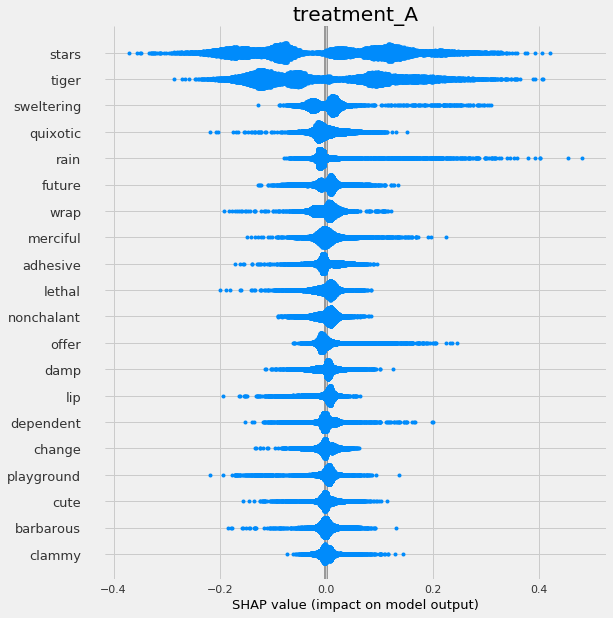

In [59]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

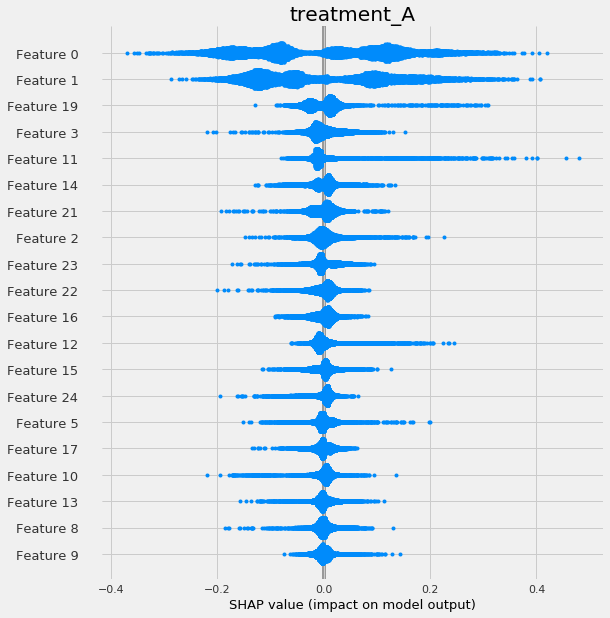

In [60]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)

# Uplift Tree/Forest

Note that uplift trees/forests are only implemented for classification at the moment, hence the following section uses a different synthetic data generation process.

### UpliftTreeClassifier

In [61]:
from causalml.dataset import make_uplift_classification

df, x_names = make_uplift_classification()

In [62]:
uplift_tree = UpliftTreeClassifier(control_name='control')

uplift_tree.fit(X=df[x_names].values,
                treatment=df['treatment_group_key'].values,
                y=df['conversion'].values)

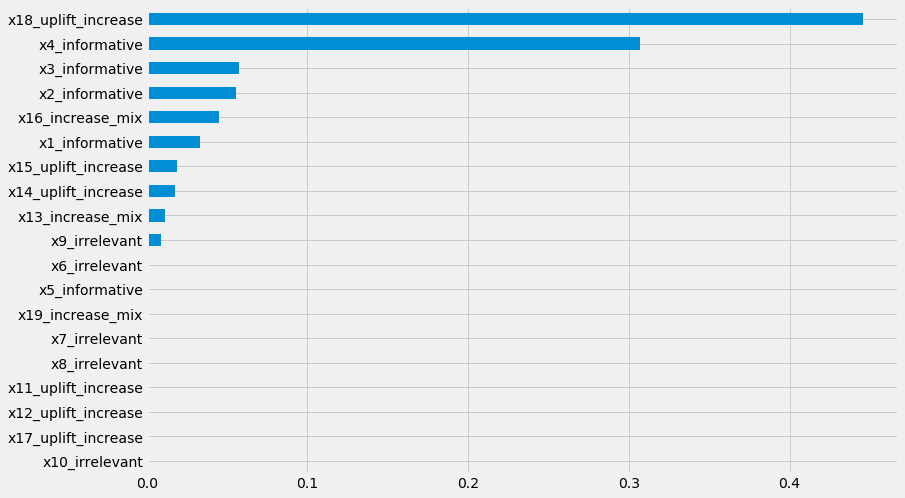

In [63]:
pd.Series(uplift_tree.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

### UpliftRandomForestClassifier

In [64]:
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=df[x_names].values,
              treatment=df['treatment_group_key'].values,
              y=df['conversion'].values)

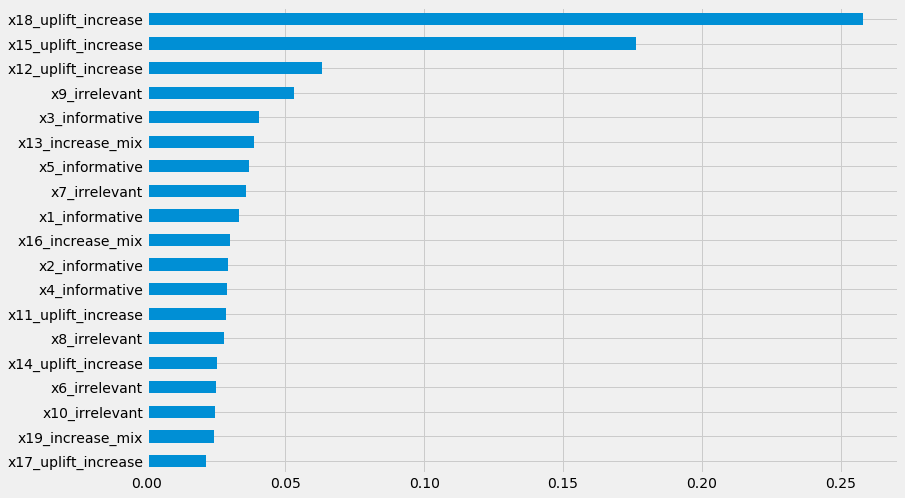

In [65]:
pd.Series(uplift_rf.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))